In [ ]:
pip install -U matplotlib

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
#Load data from local drive 
from google.colab import files
uploaded = files.upload()

Saving monthly_milk_production.csv to monthly_milk_production (1).csv


In [ ]:
#Load data set
df = pd.read_csv('monthly_milk_production.csv', index_col='Date',parse_dates=True)
df.index.freq = 'MS' 

In [ ]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


<AxesSubplot:xlabel='Date'>

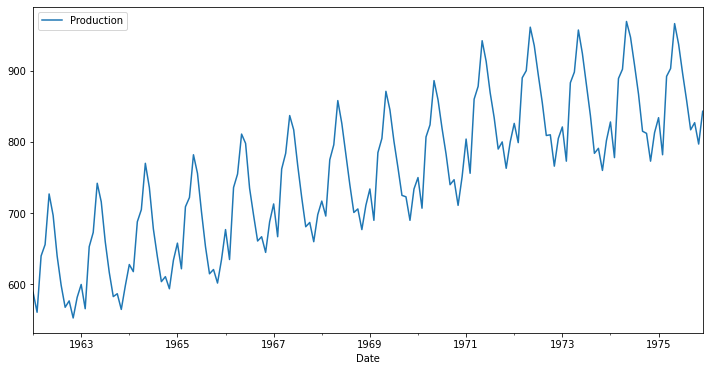

In [ ]:
df.plot(figsize=(12,6))

We see that there is some sort of seasonality repeating pattern and the general trend increasing with time.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


To perform the decomposition on Prodiction column, we have:

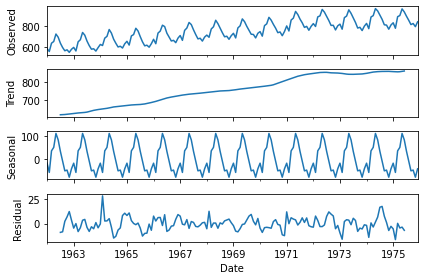

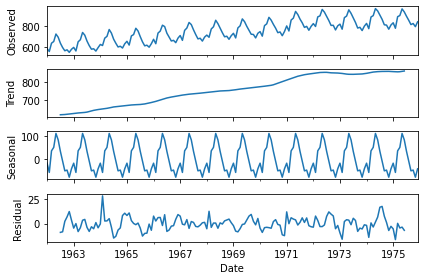

In [ ]:
results = seasonal_decompose(df['Production'])
results.plot()

The above figure shows us different components of the previous main graph. The first graph shows the similar graph as before. The second one shows the trend by isolating the trend and removing seasonality part. We see there is generally increasing trend with time. The season part of the graph, the third graph, shows just the seasonality by subtracting and removing the trend from the original graph and we can see a clear seasonal pattern over here. The fourth graph is the residual part, basically there is what cannot be explained by the trend or seasonality. It is the noise part of the dataset.

Check the length of the dataset to decide splitting it to train and test parts:

In [ ]:
len(df)

168

Consider the last 12 datas of whole dataset as testing dataset. It is the last 12 months. The remain 156 months are considered as training dataset.

In [ ]:
train = df.iloc[:156]
test = df.iloc[156:]

Now, we want to preprocess the data by Using MinMaxScalar

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
df.head(), df.tail()

(            Production
 Date                  
 1962-01-01         589
 1962-02-01         561
 1962-03-01         640
 1962-04-01         656
 1962-05-01         727,             Production
 Date                  
 1975-08-01         858
 1975-09-01         817
 1975-10-01         827
 1975-11-01         797
 1975-12-01         843)

In [ ]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
scaled_train[:10] #All values are in the range of 0 to 1

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

Let's format the model to give it to neural network.

First, assume we have the data of the first three months and we want to predict the fourth month:

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
# define generator to generate time series
n_input = 3
n_features = 1 #One feature means univariate problem. Since we have only one column of timeseries. If we have multiple columns, it is multivariate problem
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1) #the first three values are taken as one batch, using that
#to predict the fourth value

In [ ]:
X,y = generator[0] #See the first value of generator and extract input X(three value) and output y(one value)
print(f'Given the Array: \n {X.flatten()}')
print(f'Predict this: \n {y}')

Given the Array: 
 [0.08653846 0.01923077 0.20913462]
Predict this: 
 [[0.24759615]]


In [ ]:
X.shape #(1,3,1): at time, there is one row, 3 columns and the fourth value which is 1 is the number of features

(1, 3, 1)

In [ ]:
# We do the same thing, but now instead of 3, we solve for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1) 

Call the sequential, the dense and the LSTM classes

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Make the model:

In [ ]:
# define model
model = Sequential() #define model sequential to have layer by layer
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features))) #add LSTM layer with 100 nodes 
model.add(Dense(1)) #final output layer and make the final prediction
model.compile(optimizer='adam', loss='mse') #compile the model

In [ ]:
#print the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


Now, we want to fit the model:

In [ ]:
# fit model
model.fit(generator, epochs=30)

Epoch 1/30
144/144 [==============================] - 3s 7ms/step - loss: 0.0436
Epoch 2/30
144/144 [==============================] - 1s 7ms/step - loss: 0.0235
Epoch 3/30
144/144 [==============================] - 1s 7ms/step - loss: 0.0200
Epoch 4/30
144/144 [==============================] - 1s 7ms/step - loss: 0.0152
Epoch 5/30
144/144 [==============================] - 1s 7ms/step - loss: 0.0093
Epoch 6/30
144/144 [==============================] - 1s 7ms/step - loss: 0.0062
Epoch 7/30
144/144 [==============================] - 1s 7ms/step - loss: 0.0051
Epoch 8/30
144/144 [==============================] - 1s 7ms/step - loss: 0.0058
Epoch 9/30
144/144 [==============================] - 1s 7ms/step - loss: 0.0040
Epoch 10/30
144/144 [==============================] - 1s 7ms/step - loss: 0.0036
Epoch 11/30
144/144 [==============================] - 1s 7ms/step - loss: 0.0046
Epoch 12/30
144/144 [==============================] - 1s 7ms/step - loss: 0.0044
Epoch 13/30
144/144 [====

Now, we want to plot loss per epoch:

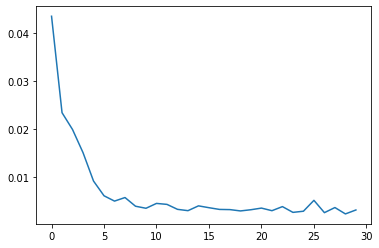

In [ ]:
loss_per_epoch = model.history.history['loss'] #Display Deep Learning Model Training History in Keras (history records training metrics includes loss and accuracy for each epoch )
plt.plot(range(len(loss_per_epoch)), loss_per_epoch) #We can use the data collected in the history object to create plots

In [ ]:
loss_per_epoch

[0.043571557849645615,
 0.023483801633119583,
 0.019980603829026222,
 0.01516137644648552,
 0.009251680225133896,
 0.006183318328112364,
 0.005076272878795862,
 0.005817567463964224,
 0.004008641466498375,
 0.0035819406621158123,
 0.004593266639858484,
 0.004391383845359087,
 0.0033602602779865265,
 0.0030839310493320227,
 0.00408528558909893,
 0.0037005236372351646,
 0.003342814976349473,
 0.003303314559161663,
 0.003028131788596511,
 0.0032796591985970736,
 0.0036192999687045813,
 0.0030780143570154905,
 0.003928115125745535,
 0.0027278149500489235,
 0.0029674351681023836,
 0.0052336654625833035,
 0.002669575624167919,
 0.0037348121404647827,
 0.0024067824706435204,
 0.0032285870984196663]

In [ ]:
range(len(loss_per_epoch))

range(0, 30)

How to make the predictions?

In [ ]:
last_train_batch = scaled_train[-12:] # taking the last 12 months values in the training set to make the prediction for the first value in the test set

In [ ]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features)) # reshape it in the format that we have before like (1,3,1)
#Why we do reshape? becuase that is how the model has been trained on 

In [ ]:
model.predict(last_train_batch) # predict the first value in the testing set

array([[0.68895966]], dtype=float32)

To compare the above predicted result with the first actual value in the testing set:

In [ ]:
# see how the actual test value was:
scaled_test[0]

array([0.67548077])

Now, we can predict the testing set

Here, we take the 12 values to make a next prediction. Then,using that prediction, it's getting a new input of 12 values and using that it's again making a prediction

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:] # get the last 12 values in the training set
current_batch = first_eval_batch.reshape((1, n_input, n_features)) # the current input or the current batch of 12 values

for i in range(len(test)):
  #print(i)
  # get the prediction value for the first batch
  current_pred = model.predict(current_batch)[0] # use the last 12 values in order to make the prediction. 0 means towards row not column

  # append the prediction into the array
  test_predictions.append(current_pred)

  # use the prediction to update the batch and remove the first value
  current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1) #taking the current batch while dropping its first input, append current prediction to it,
  # current_batch[:,1:,:] means dropping the first input. axis=1 means appending it along the column
# Ex: if current batch is [1,2,3], then predictionis [4]. Then next batch will be [2,3,4] to predict [5]. So, [1] was dropping  

In [ ]:
test_predictions

[array([0.68895966], dtype=float32),
 array([0.71596587], dtype=float32),
 array([0.90997845], dtype=float32),
 array([1.0114869], dtype=float32),
 array([1.1111249], dtype=float32),
 array([1.1083733], dtype=float32),
 array([1.0353343], dtype=float32),
 array([0.9079941], dtype=float32),
 array([0.7726714], dtype=float32),
 array([0.7056668], dtype=float32),
 array([0.67349875], dtype=float32),
 array([0.7023535], dtype=float32)]

One problem is that the range of test predictions values is that these values are in a range of 0 to 1. So, we have to tranfrom it back to the original scale becuase the original test values are about 900:

In [ ]:
test.head()

,Production
Date,
1975-01-01,834
1975-02-01,782
1975-03-01,892
1975-04-01,903
1975-05-01,966


In [ ]:
true_predictions = scaler.inverse_transform(test_predictions) #tranfrom test values back to the original scale becuase the original test values

In [ ]:
test['Predictions'] = true_predictions #add Predictions as an np array to test dataframe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test.head()

,Production,Predictions
Date,,
1975-01-01,834,839.607218
1975-02-01,782,850.841801
1975-03-01,892,931.551035
1975-04-01,903,973.778545
1975-05-01,966,1015.227947


<AxesSubplot:xlabel='Date'>

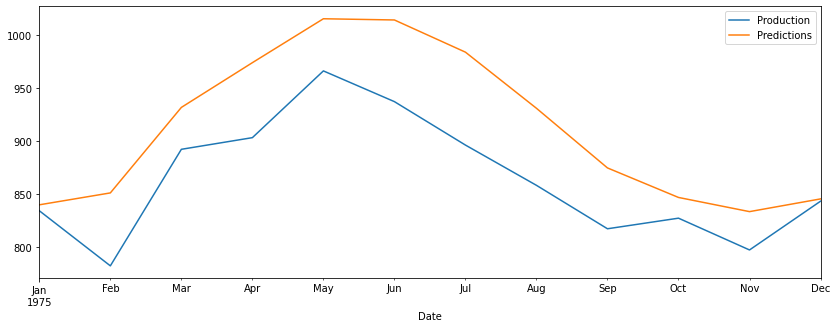

In [ ]:
test.plot(figsize=(14,5))

The above figure shows how the prediction compare to the predictions and we see that they are pretty similar and the model has done a good job.

If we want to put a number to how good a prediction is, we can simply calculate the root mean square error:

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test['Production'], test['Predictions'])) # original testing values and the predictions
print(rmse)

56.03878051682608


Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit. Root mean square error is commonly used in climatology, **forecasting**, and regression analysis to verify experimental results.

rmse
Where:

**RMSE = sqrt((f-O)^2)/N)**

f = forecasts (expected values or unknown results),

o = observed values (known results).


Reference for the LSTM coding:

https://www.youtube.com/watch?v=S8tpSG6Q2H0&ab_channel=NachiketaHebbar

**How to build a simple GRU model in Keras with Tensorflow?**

1. Creating a Simple GRU Neural Network with Keras

  1. Importing the Right Modules

 2. Adding Layers to Your Model

2. Training and Testing our Gated Recurrent Unit RNN on the MNIST Dataset
  1. Load the MNIST dataset
  2. Compile the GRU model
  3. Train and Fit the Model
  4. Test your GRU Model

Using Keras and Tensorflow makes building neural networks much easier to build. It’s much easier to build neural networks with these libraries than from scratch. 

To follow along, you’ll need to install tensorflow which you can do using the line in the terminal below.

In [ ]:
pip install tensorflow 

**Importing the Right Modules**

The first thing we need to do is import the right modules. For this example, we’re going to be working with tensorflow. We don’t technically need to do the bottom two imports, but they save us time when writing so when we add layers, we don’t need to type **tf.keras.layers.** but can rather just write **layers**.

In [ ]:
# python imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import LSTM

In [ ]:
from keras.layers import GRU

In [ ]:
# Creating GRU RNN Model in Keras
model_GRU = Sequential() #define model sequential to have layer by layer (I named the model as model_GRU to be different than previous model of LSTM)
model_GRU.add(GRU(100, input_shape=(n_input, n_features)))
model_GRU.add(Dense(1))
model_GRU.compile(optimizer='adam', loss='mse') #compile the model

In [ ]:
model_GRU.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 100)               30900     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model
model_GRU.fit(generator, epochs=30)

Epoch 1/30
144/144 [==============================] - 4s 11ms/step - loss: 0.0310
Epoch 2/30
144/144 [==============================] - 2s 13ms/step - loss: 0.0170
Epoch 3/30
144/144 [==============================] - 2s 12ms/step - loss: 0.0135
Epoch 4/30
144/144 [==============================] - 2s 14ms/step - loss: 0.0101
Epoch 5/30
144/144 [==============================] - 2s 15ms/step - loss: 0.0079
Epoch 6/30
144/144 [==============================] - 2s 15ms/step - loss: 0.0067
Epoch 7/30
144/144 [==============================] - 2s 15ms/step - loss: 0.0059
Epoch 8/30
144/144 [==============================] - 2s 13ms/step - loss: 0.0057
Epoch 9/30
144/144 [==============================] - 2s 16ms/step - loss: 0.0071
Epoch 10/30
144/144 [==============================] - 2s 15ms/step - loss: 0.0054
Epoch 11/30
144/144 [==============================] - 2s 15ms/step - loss: 0.0052
Epoch 12/30
144/144 [==============================] - 2s 13ms/step - loss: 0.0048
Epoch 13/30
1

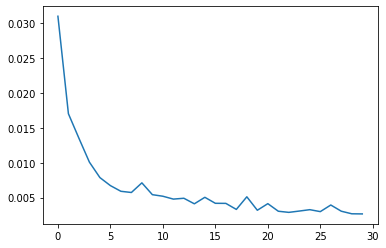

In [ ]:
loss_per_epoch = model_GRU.history.history['loss'] #Display Deep Learning Model Training History in Keras (history records training metrics includes loss and accuracy for each epoch )
plt.plot(range(len(loss_per_epoch)), loss_per_epoch) #We can use the data collected in the history object to create plots

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:] # get the last 12 values in the training set
current_batch = first_eval_batch.reshape((1, n_input, n_features)) # the current input or the current batch of 12 values

for i in range(len(test)):
  #print(i)
  # get the prediction value for the first batch
  current_pred = model_GRU.predict(current_batch)[0] # use the last 12 values in order to make the prediction. 0 means towards row not column

  # append the prediction into the array
  test_predictions.append(current_pred)

  # use the prediction to update the batch and remove the first value
  current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1) #taking the current batch while dropping its first input, append current prediction to it,
  # current_batch[:,1:,:] means dropping the first input. axis=1 means appending it along the column
# Ex: if current batch is [1,2,3], then predictionis [4]. Then next batch will be [2,3,4] to predict [5]. So, [1] was dropping  

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions) #tranfrom test values back to the original scale becuase the original test values

In [ ]:
test['Predictions'] = true_predictions #add Predictions as an np array to test dataframe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test.head()

,Production,Predictions
Date,,
1975-01-01,834,813.139921
1975-02-01,782,831.571308
1975-03-01,892,869.535772
1975-04-01,903,914.719852
1975-05-01,966,962.723606


<AxesSubplot:xlabel='Date'>

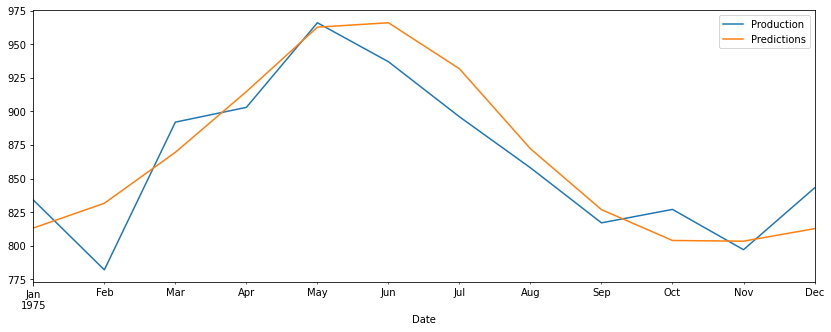

In [ ]:
test.plot(figsize=(14,5))

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test['Production'], test['Predictions'])) # original testing values and the predictions
print(rmse)

24.93011198711782


Conclusion:

GRU trains faster than LSTM. A GRU is basically an LSTM without an output gate. They perform similarly to LSTMs for most tasks but do better on  smaller datasets and less frequent data as we saw in this codes. We also learned that a GRU is just a fancy RNN with gates. We built a simple sequential GRU with one layer. 